# Forecasting Flu Trends with skforecast: A Python Walkthrough

Hey there! Today, we're diving into predicting flu trends using Python's skforecast library. This tool is a game-changer for autoregressive models, where we use past data to guess what's coming next. This is super helpful for forecasting diseases that show a regular up-and-down trend, like influenza.

**Why skforecast?**

- It's built to work with scikit-learn regressors and easily integrates into your existing pipelines.
- It provides a comprehensive set of tools for model training, validation, and prediction, making autoregressive modeling easy.
- It includes user-friendly feature engineering, hyperparameter tuning, and model selection funtionalities 

Autoregression and forecasting can get really complicated really quickly. By letting skforecast handle the intricacies of time series analysis, users can focus on the important parts of their projects: meaning and application.


---
## Case Study: Influenza in Kent County, Michigan

Flu forecasting is vital for timely public health planning and response, yet little is known about its application in local public health. This tutorial demonstrates the application of the skforecast library to assess the utility of several different machine learning algorithms for influenza prediction in Kent County, MI. 

In [16]:
# Data Manipulation
# ======================================================
import pandas as pd 
import numpy as np
from helper_functions import *
import ast

# Models
# ======================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import ElasticNetCV, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

# Reading Secrets
# ======================================================
cfg = configparser.ConfigParser()
cfg.read('secrets.ini')
ROOT_PATH = path.abspath(cfg.get('default','root'))
DATA_PATH = path.join(ROOT_PATH, 'datasets/data')

The dataset is provided by the Michigan Disease Surveillance System. It represents reported case counts of influenza-like-illness in Kent County between 2005-2019.

To start, we split the dataset into training, validation, and testing sets

In [9]:
# fetching and preprocessing dataset
# influenza cases in Kent County, MI

df = fetch_preprocess_dataset()[['cases']] 

# Splitting the dataset

end_train, end_validation, df_train, df_val, df_test = \
    train_test_validate_split(
                    df               = df,
                    end_train        = date(2015,12,31), 
                    end_validation   = date(2017,12,31)
                    )


Dates train      : 2004-12-26 00:00:00 --- 2015-12-27 00:00:00  (n=575)
Dates validacion : 2016-01-03 00:00:00 --- 2017-12-31 00:00:00  (n=105)
Dates test       : 2017-12-31 00:00:00 --- 2019-12-29 00:00:00  (n=105)


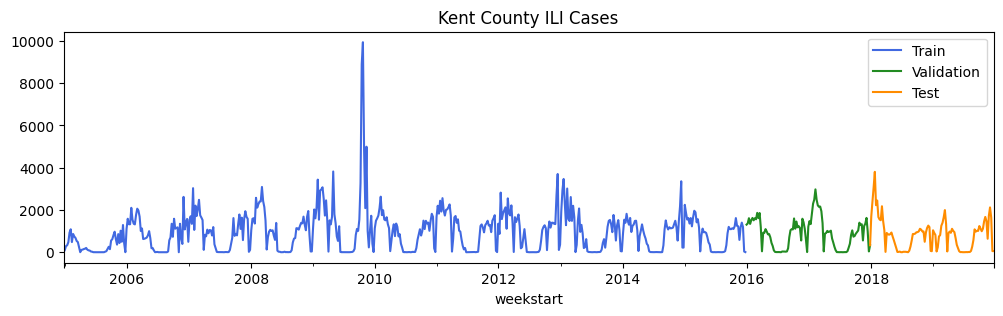

In [14]:
fig, ax = plt.subplots(figsize=(12, 3))

df_train.rename(columns={'cases':'Train'}).plot(ax=ax, color='royalblue')
df_val.rename(columns={'cases':'Validation'}).plot(ax=ax, color='forestgreen')
df_test.rename(columns={'cases':'Test'}).plot(ax=ax, color='darkorange')

ax.set_title('Kent County ILI Cases')
ax.legend(['Train', 'Validation', 'Test'])

skforecast follows the scikit-learn API style, which makes its tools feel very approachable. Here we instantiate the following regressors:

- Random Forest
- Gradient Boosting
- Ridge
- Elastic Net
- Light Gradient Boosing

The details of these models are outside the scope of this tutorial, but suffice to say that they're all used to predict continuous numberical values.

In [ ]:
# creating multiple models, then tuning their hyperparameters with grid search

models = [
        RandomForestRegressor(), 
        GradientBoostingRegressor(),
        RidgeCV(),
        ElasticNetCV(),
        LGBMRegressor(),
        ]

param_grids = {
    'RandomForestRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, 40, 80]},
    'GradientBoostingRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, 40, 80]},
    'RidgeCV': {'alphas': [0.01, 0.1, 1, 10]},
    'ElasticNetCV': {'l1_ratio': [0.1, 0.5, 0.9]},
    'LGBMRegressor': {'n_estimators': [10, 50, 100, 200], 'max_depth': [5, 10, 20, 40, 80]},
            }

lags_grid = [1,2,3,52,[1,2],[1,3],[1,52],[1,2,3],[1,2,52],[1,3,52],[1,2,3,52]]

df_results = pd.DataFrame()

for i, model in enumerate(models):
    print(f"Grid search for regressor: {model.__class__.__name__}")
    print('-------------------------------------')

    forecaster = ForecasterAutoreg( 
        regressor = model,
        lags      = 1
    )

    param_grid = param_grids[list(param_grids)[i]]

    results = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = df[:end_validation]['cases'],
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        initial_train_size = len(df_train),
        fixed_train_size   = True,
        steps              = 1,
        refit              = False,
        metric             = 'mean_absolute_error',
        return_best        = False,
        verbose            = False,
        show_progress      = True,

    )

    results['model'] = list(param_grids)[i]

    df_results = pd.concat([df_results, results])

df_results = df_results.sort_values(by='mean_absolute_error')
df_results.to_csv('tutorial_results.csv')

Each model undergoes a gridsearching process to tune the model parameters, based on mean absolute error. The lags grid selects ILI case counts from prior weeks which will serve as model predictors. 

The steps parameter specifies how many weeks ahead we will be predicting.

In [113]:
df_results.head(10)

,lags,params,mean_absolute_error,max_depth,n_estimators,model,alphas,n_alphas,selection,l1_ratio
0,[ 1 2 3 52],"{'max_depth': 10, 'n_estimators': 200}",165.495443,10.0,200.0,RandomForestRegressor,NaN,NaN,NaN,NaN
1,[ 1 2 52],"{'max_depth': 10, 'n_estimators': 100}",166.069820,10.0,100.0,RandomForestRegressor,NaN,NaN,NaN,NaN
2,[ 1 2 3 52],"{'max_depth': 80, 'n_estimators': 200}",166.308048,80.0,200.0,RandomForestRegressor,NaN,NaN,NaN,NaN
3,[ 1 2 3 52],"{'max_depth': 40, 'n_estimators': 200}",166.308048,40.0,200.0,RandomForestRegressor,NaN,NaN,NaN,NaN
4,[ 1 2 52],"{'max_depth': 10, 'n_estimators': 200}",166.729715,10.0,200.0,RandomForestRegressor,NaN,NaN,NaN,NaN
5,[ 1 2 3 52],"{'max_depth': 20, 'n_estimators': 200}",167.234139,20.0,200.0,RandomForestRegressor,NaN,NaN,NaN,NaN
6,[ 1 2 3 52],"{'max_depth': 10, 'n_estimators': 100}",167.674256,10.0,100.0,RandomForestRegressor,NaN,NaN,NaN,NaN
7,[ 1 2 52],"{'max_depth': 40, 'n_estimators': 200}",167.875441,40.0,200.0,RandomForestRegressor,NaN,NaN,NaN,NaN
8,[ 1 2 52],"{'max_depth': 80, 'n_estimators': 200}",167.875441,80.0,200.0,RandomForestRegressor,NaN,NaN,NaN,NaN
9,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...,"{'max_depth': 80, 'n_estimators': 200}",167.984810,80.0,200.0,RandomForestRegressor,NaN,NaN,NaN,NaN


In [115]:
# selecting the best hyperparameters for each model

best_models = pd.concat(
    [pd.DataFrame(
        df_results.loc[
            df_results.loc[
                df_results['model'] == m.__class__.__name__, 'mean_absolute_error'
                ].idxmin(),:
                    ]
                ).T for m in models
    ]
).set_index('model')

In [116]:
best_models

,lags,params,mean_absolute_error,max_depth,n_estimators,alphas,n_alphas,selection,l1_ratio
model,,,,,,,,,
RandomForestRegressor,[ 1 2 3 52],"{'max_depth': 10, 'n_estimators': 200}",165.495443,10.0,200.0,NaN,NaN,NaN,NaN
GradientBoostingRegressor,[ 1 2 52],"{'max_depth': 5, 'n_estimators': 50}",170.64509,5.0,50.0,NaN,NaN,NaN,NaN
RidgeCV,[ 1 3 52],{'alphas': 10},233.389028,NaN,NaN,10.0,NaN,NaN,NaN
ElasticNetCV,[ 1 52],{'l1_ratio': 0.1},238.065016,NaN,NaN,NaN,NaN,NaN,0.1
LGBMRegressor,[ 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...,"{'max_depth': 5, 'n_estimators': 50}",181.331617,5.0,50.0,NaN,NaN,NaN,NaN


In [136]:
# convenience functions to manage parameter formatting

def params_to_dict(params):
    return ast.literal_eval(params)

def lags_to_list(lags):
    lags = lags.replace('[','').replace(']','').split()
    return list(map(int, lags))

Based on the results of our gridsearch, we now train our models on the training dataset with optimized hyperparameters

In [ ]:
# fitting each optimized model with training data and predicting the test data

rf_forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(**params_to_dict(best_models.loc['RandomForestRegressor', 'params'])),
        lags      = lags_to_list(best_models.loc['RandomForestRegressor', 'lags'])                        
                                )

gb_forecaster = ForecasterAutoreg(
        regressor = GradientBoostingRegressor(**params_to_dict(best_models.loc['GradientBoostingRegressor', 'params'])),
        lags      = lags_to_list(best_models.loc['GradientBoostingRegressor', 'lags'])                  
                                )

ridge_forecaster = ForecasterAutoreg(
        regressor = RidgeCV(**params_to_dict(best_models.loc['RidgeCV', 'params'])),
        lags      = lags_to_list(best_models.loc['RidgeCV', 'lags'])                      
                                )

elastic_forecaster = ForecasterAutoreg(
        regressor = ElasticNetCV(**params_to_dict(best_models.loc['ElasticNetCV', 'params'])),
        lags      = lags_to_list(best_models.loc['ElasticNetCV', 'lags'])                      
                                )

lgbm_forecaster = ForecasterAutoreg(
        regressor = LGBMRegressor(**ast.literal_eval(best_models.loc['LGBMRegressor', 'params'])),
        lags      = lags_to_list(best_models.loc['LGBMRegressor', 'lags'])                     
                                )

preds_df = pd.DataFrame()

for forecaster, name in zip([rf_forecaster, gb_forecaster, ridge_forecaster, elastic_forecaster, lgbm_forecaster],
                                ['RandomForest', 'GradientBoosting', 'Ridge', 'ElasticNet', 'LGBM']):

        forecaster.fit(y = df[:end_validation]['cases'])
        pred = forecaster.predict(steps = len(df_test))
        preds_df[name] = pred

Next we examine model performances by plotting the predictions and the actual test data

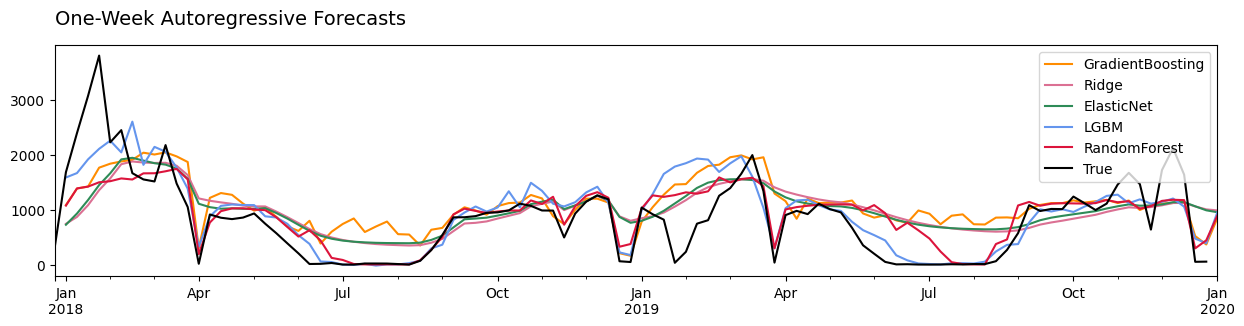

In [138]:
# plotting the predictions

fig, ax = plt.subplots(figsize=(15, 3))

for p, c in zip(['GradientBoosting', 'Ridge', 
                'ElasticNet', 'LGBM', 'RandomForest'], 
                ['darkorange', 'palevioletred', 
                'seagreen', 'cornflowerblue', 'crimson']):
        
        preds_df[p].plot(ax=ax, color=c)

df_test['cases'].rename('True').plot(ax=ax, color='black')

ax.set_title('One-Week Autoregressive Forecasts',
                loc='left', 
                fontdict={'fontsize': 14,
                        'fontweight': 50,
                        'color': 'black',
                        'verticalalignment': 'baseline',
                        'horizontalalignment': 'left'},
                pad=15)
plt.xlabel('')
ax.legend()


Some models appear to predict ILI cases better than others. The GradientBoosting, ElasticNet, and Ridge models fail to predict the lowered case counts during the summer months. The LightGradientBoosting model looks like it does better, but it's clear that the RandomForest predictions were closest to the true case counts in this period. 

We can double-check by looking at the mean absolute errors of the models.

In [139]:
# displaying the MAE for each model

best_models[['mean_absolute_error']].astype(int).rename(columns={'mean_absolute_error':'MAE'})

,MAE
model,
RandomForestRegressor,165
GradientBoostingRegressor,170
RidgeCV,233
ElasticNetCV,238
LGBMRegressor,181


Indeed, the RandomForest predictions were the closest to the true ILI case counts. The superior performance of the random forest is not surprising; similar results can been seen [here](https://doi.org/10.1007/s11042-023-15848-2), [here](http://www.biomedcentral.com/1471-2105/15/276), and [here](https://www.jmir.org/2017/11/e370/).

Random forest is also the best Kent County ILI forecasting model when exogenous regressors are added. The figure below is a sneak preview of the results of my MPH thesis analysis, where I used Google search trends, local climate/weather conditions, and emergency department visits as additional regressors to boost Kent County autoregressive ILI forecasting models

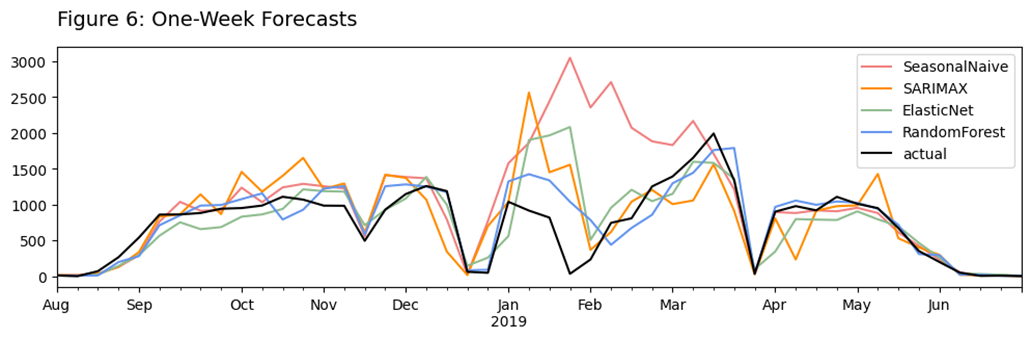

---

I'm nearly finished with my thesis, and I'm super excited to share my results with the world! I've gained mastery in time series forecasting over these last few semesters, and I have skforecast to thank for much of it. The library is straightforward and takes a lot of the guesswork out of autoregression in disease forecasting with Python. 

What's more, I had the opportunity to contribute to the code behind skforecast. As my first contribution to a major open-source project, I appreciated being able to practice my skills in source control and package management. 

And! GitHub rewarded my contribution by giving me 6 months of copilot for free. Copilot is an AI coding assistance tool that uses natural language processing to provide suggestions for code snippets and documentation. The tool has already significantly improved my coding process.

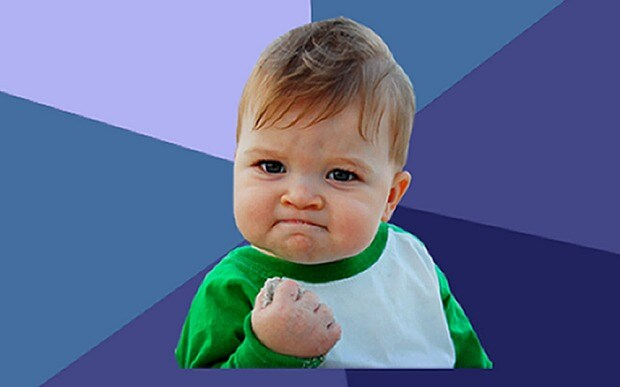

All in all, I highly recomend skforecast for all of your Python time series forecasting needs. Their [user documentation](https://skforecast.org/0.11.0/index.html) is stellar, with tons of examples and walkthroughs for varying forecasting scenarios. In addition, the code maintainers Joaquin Rodrigo and Javier Ortiz are excellent about responding to user questions and issues via their GitHub [issues tab](https://github.com/JoaquinAmatRodrigo/skforecast/issues)

---

Thanks for reading my tutorial! Please [reach out](mailto:lillian@lillianjensen.com) with any burning questions, comments, or concerns about my analysis. I'm very open to collaboration!